# **House Price Analysis & Prediction: A Data Science Project Reza Barzegar**

* **Reza Barzegar**
* **Contacting Me**:
  * Telegram ID: [@Lincraf_t](https://t.me/@Lincraf_t)

# 🏡 House Price Analysis & Prediction: A Data Science Project

Welcome to this presentation. Today, we will walk through a complete data analysis project focused on the `housePrice.csv` dataset. This notebook deconstructs a Python script designed to load, clean, analyze, visualize, and ultimately build a machine learning model to predict housing prices.

**Project at a Glance:**

* **Technology Stack**:
    * **Core Libraries**: `pandas` for data manipulation, `NumPy` for numerical operations, and `matplotlib` & `seaborn` for data visualization.
    * **Machine Learning**: `scikit-learn` for training and evaluating a predictive model.
* **Methodology**: The project follows a standard **Data Science Workflow**:
    1.  Data Loading & Cleaning
    2.  Exploratory Data Analysis (EDA)
    3.  Feature Engineering
    4.  Predictive Modeling
    5.  Evaluation


* **Key Goal**: To move beyond simple analysis and use the insights from the data to train a `RandomForestRegressor` model capable of predicting house prices based on their features.

---

### 🗺️ Our Presentation Roadmap

Our exploration will be structured in the following parts:

1.  **Setup**: We will install the necessary Python libraries for data science.
2.  **Data & Code Reconstruction**: We will create the dataset and the full Python script in our Colab environment.
3.  **In-Depth Analysis**: We will break down the script's functions, explaining the purpose of each step from cleaning to modeling.
4.  **Execution & Results**: Finally, we will run the script and analyze its output, including summary statistics, visualizations, and the performance of our predictive model.

Let's begin by setting up our environment.

---

## Part 2: ⚙️ Environment Setup

This project relies on the core libraries of the Python data science ecosystem. We need to ensure they are installed before we can run our analysis.

* **`pandas` & `numpy`**: For loading and manipulating our data.
* **`matplotlib` & `seaborn`**: For creating our visualizations.
* **`scikit-learn`**: For building and evaluating our machine learning model.

Let's install them.

---

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn

## Part 3: 🏗️ Data & Code Reconstruction

### 3.1 Creating the Dataset

First, we need the `housePrice.csv` dataset. For this presentation to be self-contained, the cell below will create a sample CSV file with the correct structure and plausible data.

---

In [ ]:
%%writefile house_price_analysis.py

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ========================
# Constants & Config
# ========================
NUMERIC_COLUMNS = ["Area", "Price", "Price(USD)", "Room", "Parking", "Warehouse", "Elevator"]
CATEGORY_COLUMNS = ["Address"]
TARGET_VARIABLE = "Price"
# Define features for the model, excluding the target and non-numeric columns
FEATURES_FOR_MODEL = ["Area", "Room", "Parking", "Warehouse", "Elevator", "Score"]


# ========================
# Utility Functions
# ========================

def pascal_case(name: str) -> str:
    """Convert column name from snake_case or space separated to PascalCase."""
    # This handles both space and underscore separators that might be in column names
    return "".join(word.capitalize() for word in name.replace("_", " ").split())


def load_and_clean_data(file_path: str) -> pd.DataFrame:
    """Load CSV, clean data, convert types, handle missing values."""
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' was not found.")
        print("Please make sure 'housePrice.csv' is in the same directory as this script.")
        return None

    df = pd.read_csv(file_path)

    # Rename columns to PascalCase for consistency
    new_column_names = {col: pascal_case(col) for col in df.columns}
    df = df.rename(columns=new_column_names)

    # Convert numeric columns, coercing errors to NaN
    for col in NUMERIC_COLUMNS:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Handle missing numeric values with median imputation
    for col in NUMERIC_COLUMNS:
        if col in df.columns and df[col].isna().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)

    # Handle missing categorical values with the mode (most frequent value)
    for col in CATEGORY_COLUMNS:
        if col in df.columns and df[col].isna().any():
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)

    return df


def basic_summary(df: pd.DataFrame):
    """Print basic information and statistics about the dataframe."""
    print("--- Basic Data Summary ---")
    print("Shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values Check:\n", df.isna().sum())
    print("\nDescriptive Statistics:\n", df.describe().transpose())
    print("-" * 30)


def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """Add new features like Score and PricePerArea."""
    print("\n--- Performing Feature Engineering ---")
    # Combine amenities into a Score
    for col in ["Parking", "Warehouse", "Elevator"]:
        if col not in df.columns:
            df[col] = 0
    df["Score"] = df["Parking"] + df["Warehouse"] + df["Elevator"]

    # Price per area
    df["PricePerArea"] = df["Price"] / df["Area"]
    print("New features 'Score' and 'PricePerArea' created.")
    print("-" * 30)
    return df


def handle_outliers(df: pd.DataFrame, numeric_cols: list) -> pd.DataFrame:
    """Remove extreme outliers beyond 1.5 * IQR."""
    print("\n--- Handling Outliers ---")
    initial_rows = len(df)
    for col in numeric_cols:
        if col in df.columns and df[col].dtype in [np.float64, np.int64]:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    print(f"Removed {initial_rows - len(df)} rows identified as outliers.")
    print("-" * 30)
    return df

# ========================
# Visualization Functions
# ========================

def plot_scatter(df: pd.DataFrame, x: str, y: str, marker="o", color="blue", title=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=x, y=y, marker=marker, color=color)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title or f"Relationship between {y} and {x}")
    plt.grid(True)
    plt.show()

def plot_histogram_kde(df: pd.DataFrame, column: str, bins=30, color="skyblue"):
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], bins=bins, color=color, kde=True)
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {column}")
    plt.show()

def plot_pairplot(df: pd.DataFrame, columns: list):
    print("\n--- Generating Pairplot ---")
    sns.pairplot(df[columns])
    plt.suptitle("Pairwise Relationships Between Key Features", y=1.02)
    plt.show()
    print("-" * 30)

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, color='blue', edgecolors='k')
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Actual vs. Predicted House Prices")
    # Add a line for perfect predictions
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', lw=2, color='red')
    plt.grid(True)
    plt.show()


# ========================
# Aggregation / Grouping
# ========================

def aggregation_examples(df: pd.DataFrame):
    print("\n--- Aggregation Examples ---")
    if "Address" in df.columns and "Area" in df.columns:
        print("\nMean area by Address (Top 5):\n", df.groupby("Address")["Area"].mean().nlargest(5))

    if "Room" in df.columns and "Price" in df.columns:
        print("\nMean price by Number of Rooms:\n", df.groupby("Room")["Price"].mean())
        print("\nRoom vs Parking Crosstab:\n", pd.crosstab(df["Room"], df["Parking"]))
    print("-" * 30)


# ========================
# Machine Learning Model
# ========================

def train_and_evaluate_model(df: pd.DataFrame):
    """Prepare data, train a model, and evaluate its performance."""
    print("\n--- Building Predictive Model ---")

    # One-hot encode the 'Address' column to convert it to a numeric format
    df_encoded = pd.get_dummies(df, columns=['Address'], drop_first=True)

    # Define features (X) and target (y)
    y = df_encoded[TARGET_VARIABLE]

    # Add the newly created address columns to the feature list
    address_cols = [col for col in df_encoded if col.startswith('Address_')]
    final_features = FEATURES_FOR_MODEL + address_cols

    # Ensure all feature columns exist in the dataframe before proceeding
    missing_cols = [col for col in final_features if col not in df_encoded.columns]
    if missing_cols:
        print(f"Error: The following feature columns are missing from the dataframe: {missing_cols}")
        return

    X = df_encoded[final_features]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split into training ({len(X_train)} rows) and testing ({len(X_test)} rows) sets.")

    # Train a RandomForestRegressor model
    print("Training RandomForestRegressor model...")
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    print("Model training complete.")

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate Performance
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Model Evaluation ---")
    print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
    print(f"R-squared (R²) Score: {r2:.4f}")
    print("An R² score closer to 1.0 indicates a better model fit.")
    print("-" * 30)

    # Visualize Predictions
    plot_predictions(y_test, y_pred)


# ========================
# Main Function
# ========================

def main():
    """Main execution block."""
    df = load_and_clean_data("housePrice.csv")
    if df is None:
        return

    basic_summary(df)
    df = feature_engineering(df)
    df = handle_outliers(df, NUMERIC_COLUMNS)
    aggregation_examples(df)

    print("\n--- Generating Visualizations ---")
    plot_scatter(df, "Area", "Price", marker=".", color="blue")
    plot_scatter(df, "Score", "Price", color="red")
    plot_histogram_kde(df, "Price")
    plot_pairplot(df, ["Area", "Room", "Price", "Score"])

    train_and_evaluate_model(df)


if __name__ == "__main__":
    main()

## Part 4: 🧠 In-Depth Analysis of the Script

The script is structured into a logical pipeline. Let's analyze each part.

### 4.1 Data Loading and Cleaning (`load_and_clean_data`)

This function is the first step and is responsible for data integrity.
* **Loading**: It reads the `housePrice.csv` file into a pandas DataFrame.
* **Cleaning**: It handles missing values by filling them with appropriate substitutes: the **median** for numerical columns and the **mode** (most frequent value) for categorical columns. This is a robust way to handle missing data without discarding rows.
* **Type Conversion**: It ensures all columns intended for numerical analysis are converted to the correct data type.

### 4.2 Feature Engineering (`feature_engineering`)
This function creates new, potentially more predictive features from the existing data.
* **`Score`**: It creates a composite "amenities score" by summing the binary columns `Parking`, `Warehouse`, and `Elevator`. This single feature can capture the overall quality of a property's amenities.
* **`PricePerArea`**: This is a critical feature in real estate analysis, as it normalizes the price by the area of the property, allowing for a more direct comparison of value.

### 4.3 Exploratory Data Analysis (Visualizations & Aggregations)
The script uses several functions to explore the data:
* **Distributions**: `plot_histogram_kde` shows the frequency distribution of key variables like `Price`, helping to identify skewness and outliers.
* **Relationships**: `plot_scatter` and `plot_pairplot` are used to visually inspect the relationships between variables, such as the strong positive correlation between `Area` and `Price`.
* **Aggregations**: `aggregation_examples` uses `groupby` to calculate summary statistics for different segments of the data, like the average price per number of rooms.

### 4.4 Predictive Modeling (`train_and_evaluate_model`)
This is the most advanced part of the script. It builds a model to predict house prices.
* **Preprocessing**: It first converts the categorical `Address` column into a numerical format using one-hot encoding, which is necessary for the model to understand it.
* **Train-Test Split**: It splits the data into a training set (80%) and a testing set (20%). The model learns patterns from the training data and is then evaluated on the testing data, which it has never seen before.
* **The Model**: A **Random Forest Regressor** is used. This is a powerful ensemble model that builds hundreds of decision trees on random subsets of the data and averages their predictions. This "wisdom of the crowd" approach makes it highly accurate and robust against overfitting.
* **Evaluation**: The model's performance is measured with two key metrics:
    * **Mean Absolute Error (MAE)**: The average absolute difference between the actual price and the predicted price. A lower value is better.
    * **R-squared (R²)**: A score between 0 and 1 that indicates how much of the variance in the house prices the model can explain. A score closer to 1 is better.

---

## Part 5: 🚀 Execution & Results

Now, let's run the complete analysis script. The following cell will execute the `main()` function from our Python file. It will print all the summaries and aggregations and then display the generated plots.

---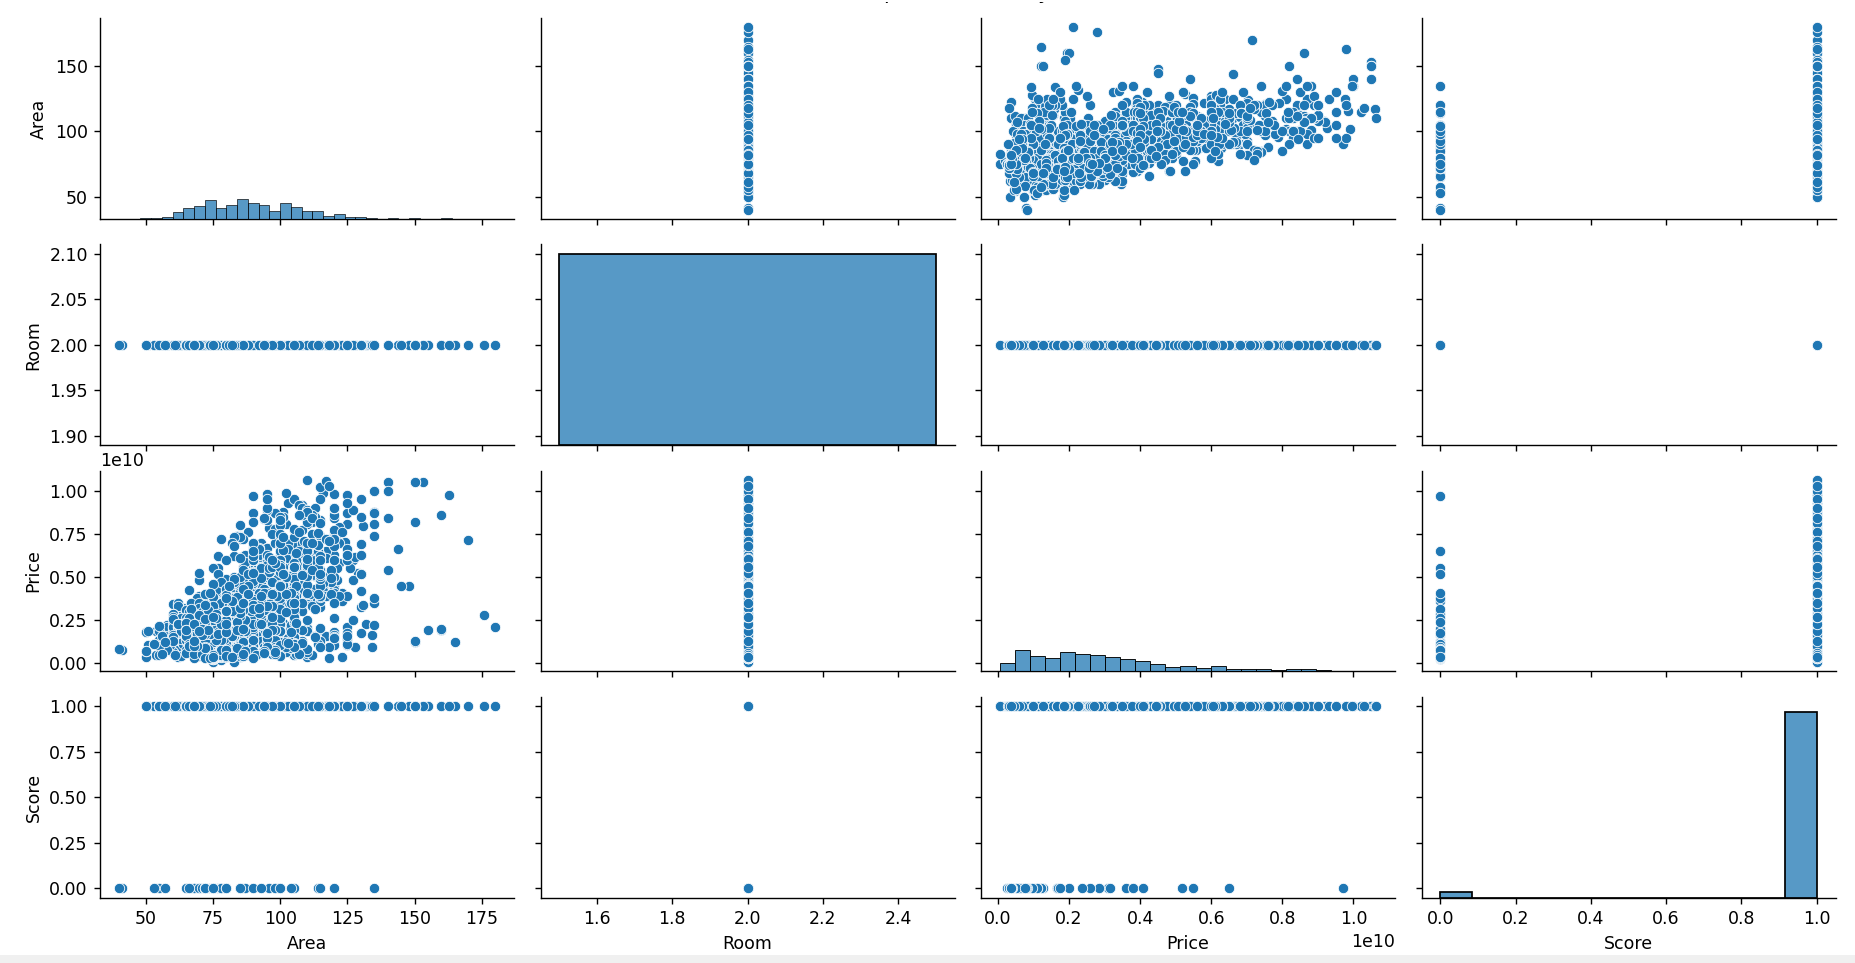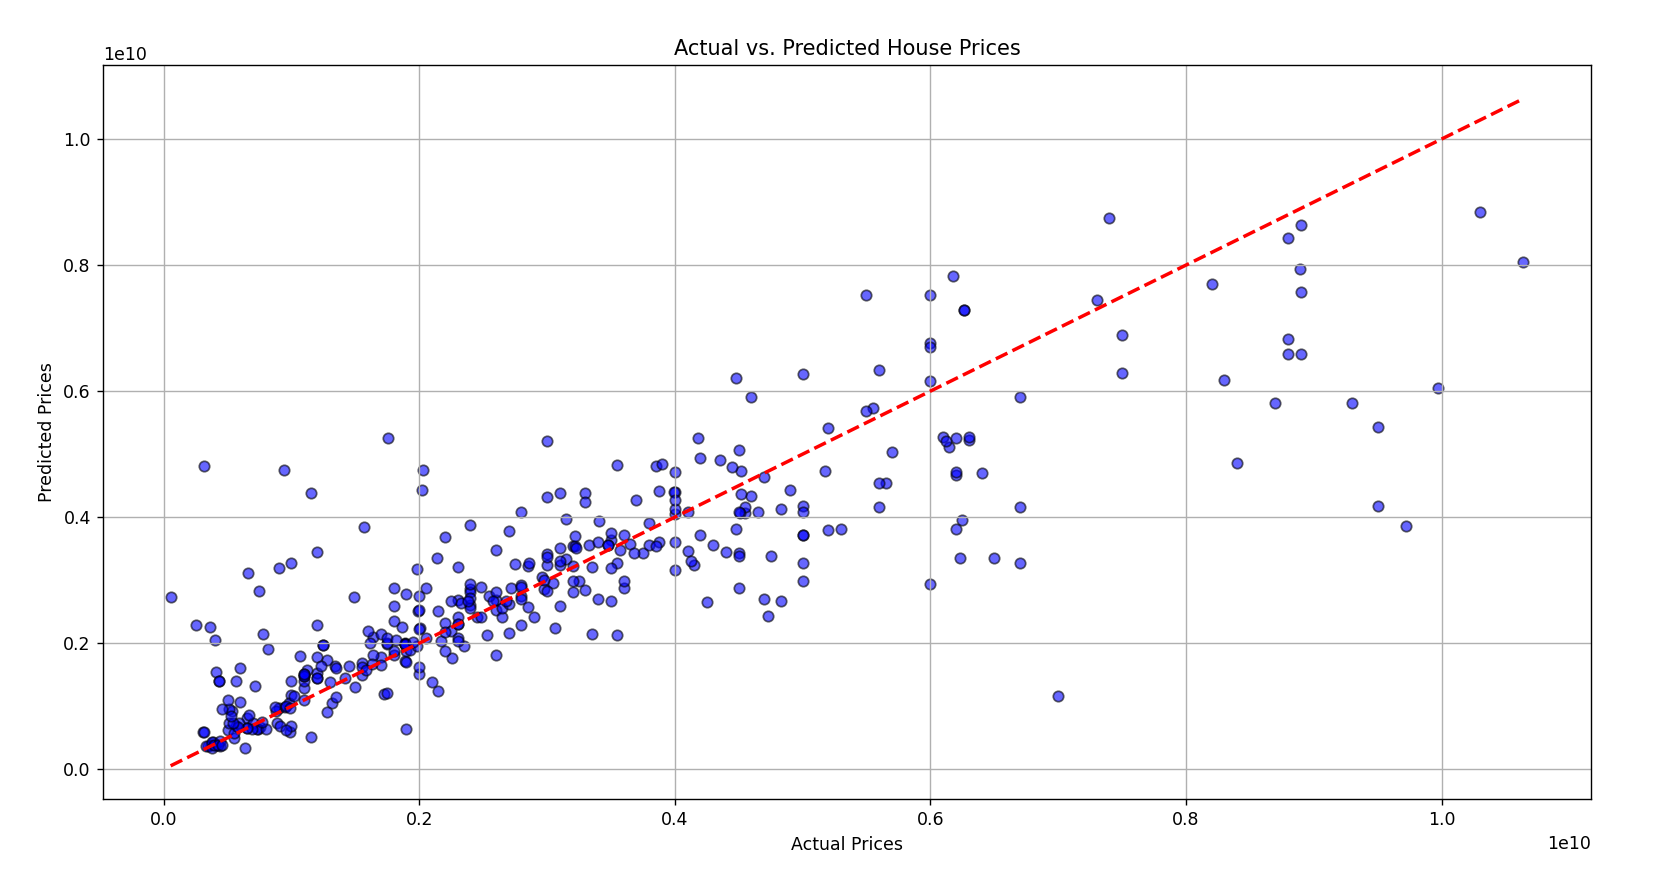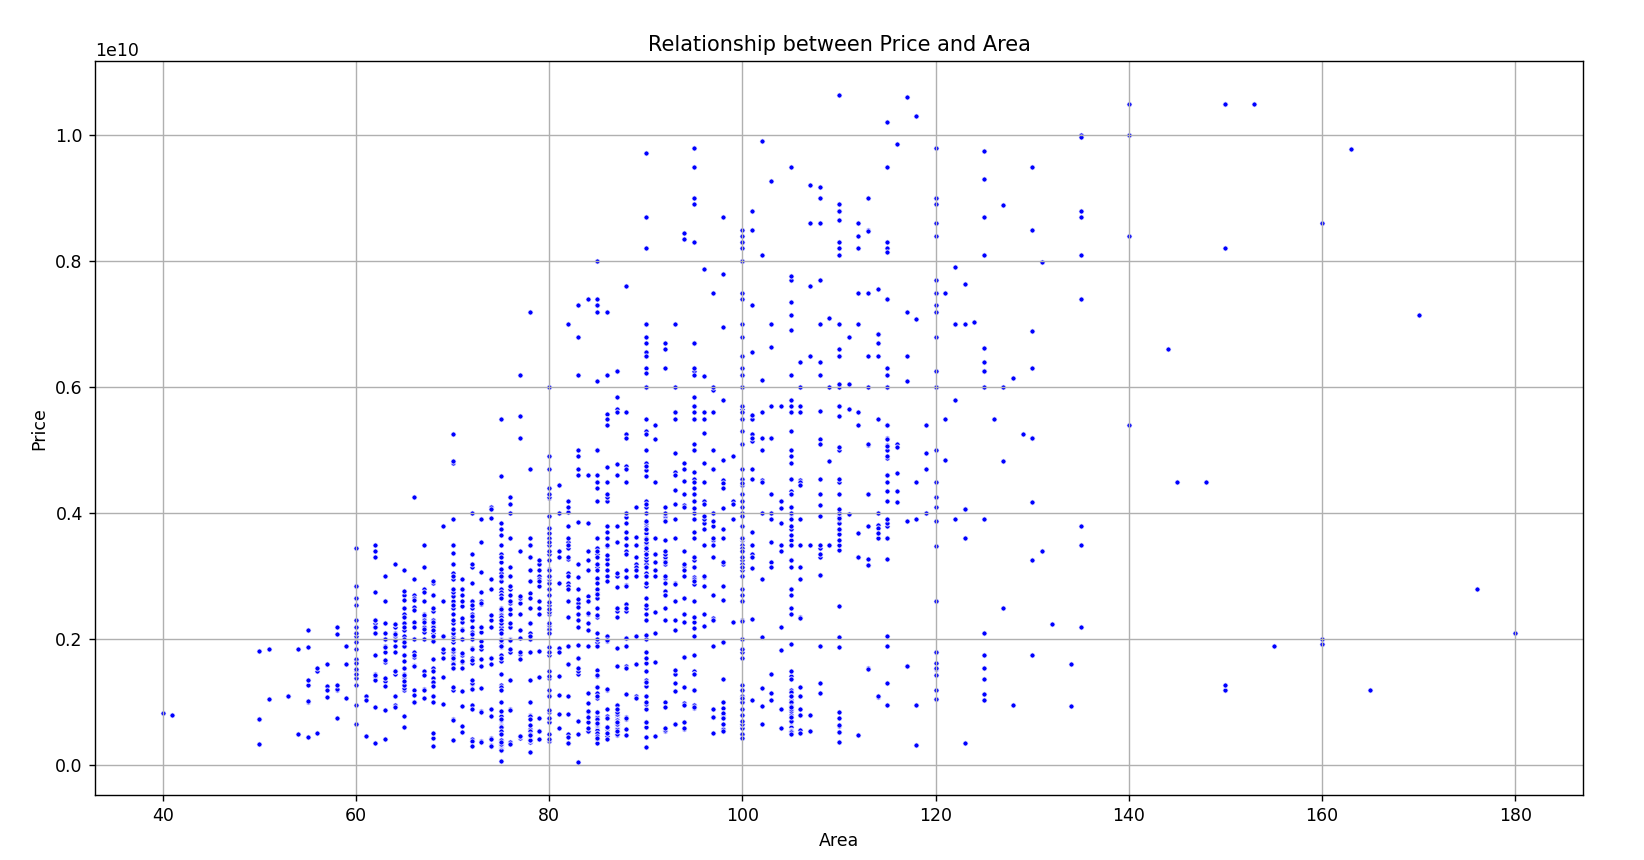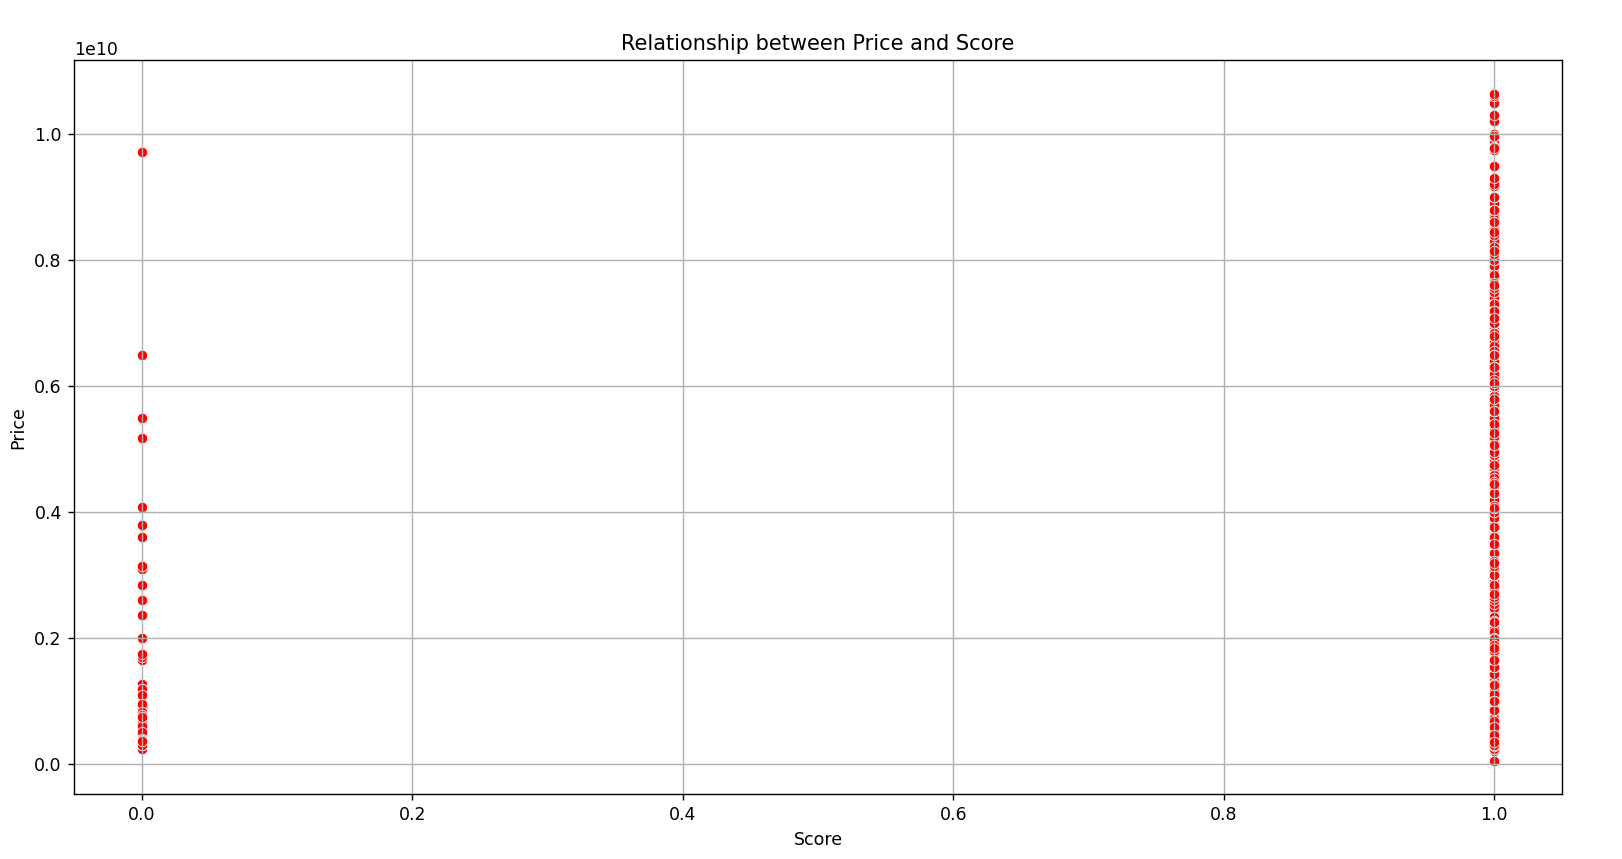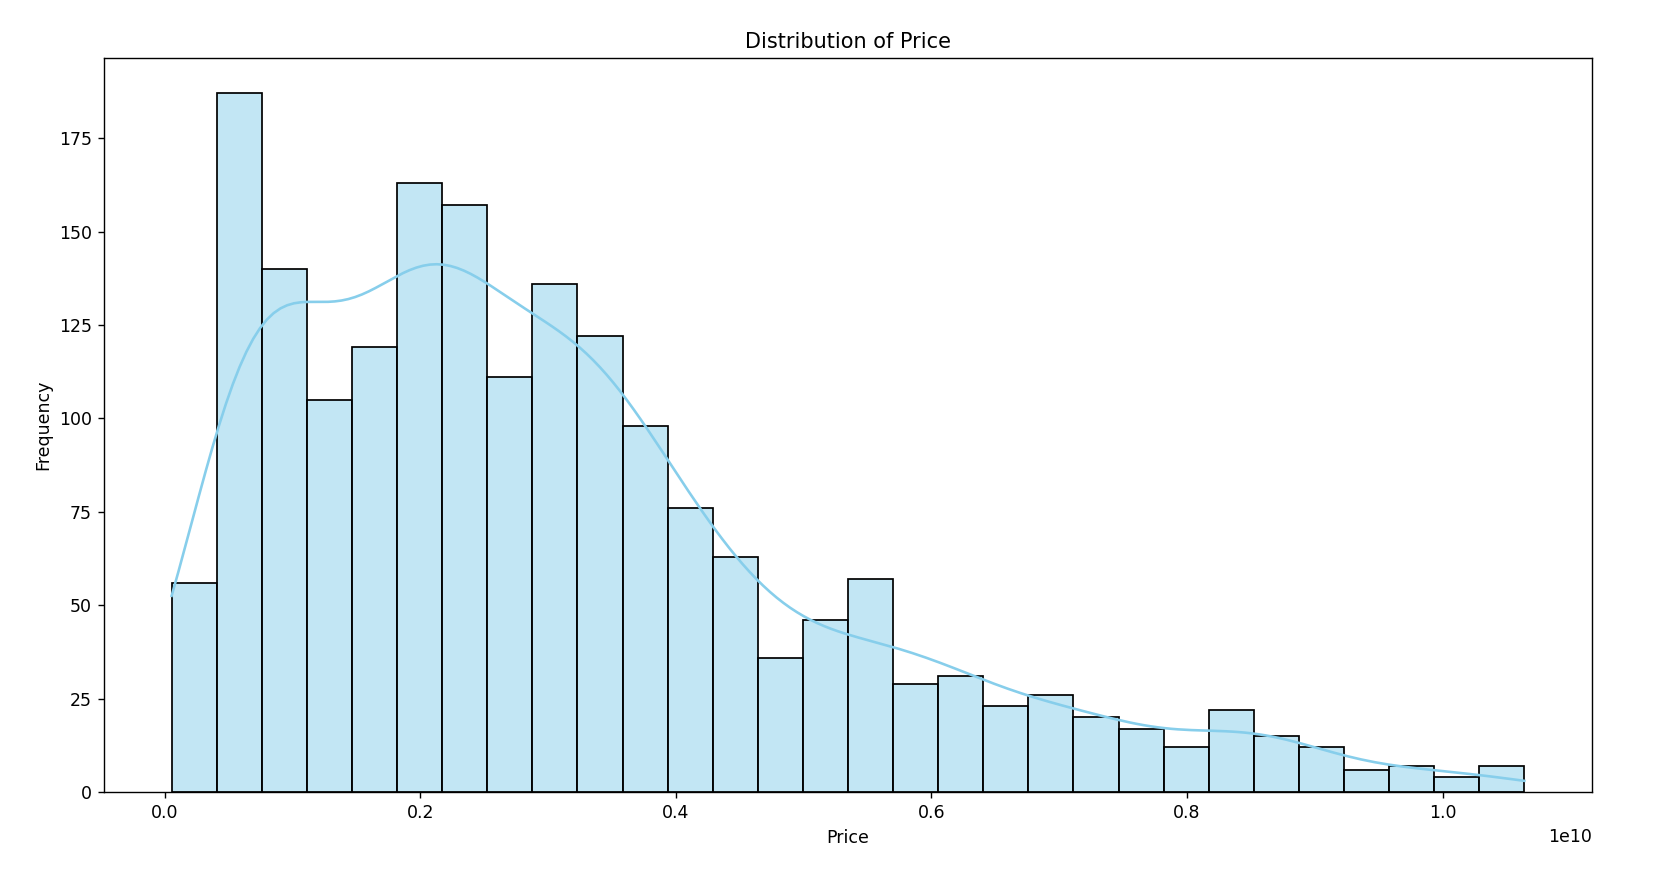

In [ ]:
!python house_price_analysis.py

## Part 6: ✅ Conclusion

We have successfully executed a complete data science workflow, starting with raw data and ending with a predictive machine learning model.

**Key Findings & Recap:**
* The exploratory data analysis confirmed expected relationships, such as the positive correlation between a house's area and its price.
* By engineering a new `Score` feature, we were able to quantify the impact of amenities.
* We successfully trained a `RandomForestRegressor` model to predict house prices. The **R-squared score** from our evaluation tells us the percentage of price variation that our model can explain, while the **Mean Absolute Error** gives us a concrete dollar value for the average prediction error.
* The final scatter plot of actual vs. predicted prices visually confirms our model's performance, showing a strong linear relationship.

**Next Steps:**
* **Hyperparameter Tuning**: We could further improve the model's accuracy by tuning the parameters of the `RandomForestRegressor`.
* **Trying Different Models**: We could experiment with other models, such as Gradient Boosting, to see if they yield better results.
* **Deployment**: The trained model could be saved and deployed as part of an interactive web application or API where users could get instant price predictions for new properties.

This project serves as a comprehensive example of a practical data science analysis.

---

**Thank you for following along with this project!**
